# Regression by Machine Learning
    - Supervised learning
    - Estimate surface NO3 level as a function of T and S
    - 1. linear regression
    - 2. Neural network
    - 3. Random forest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# load the data
ds_t=xr.open_dataset('Temperature_WOD18_OSD_qc0_profiles.nc')
ds_s=xr.open_dataset('Salinity_WOD18_OSD_qc0_profiles.nc')
ds_p=xr.open_dataset('Nitrate_WOD18_OSD_qc0_profiles.nc')

In [3]:
# read in near surface (0-50m) data
T = ds_t.Temperature[:,:11].mean('depth').to_numpy()
S = ds_s.Salinity[:,:11].mean('depth').to_numpy()
tr = ds_p.Nitrate[:,:11].mean('depth').to_numpy()
# get the coordinates
lat = ds_p.lat.to_numpy()
lon = ds_p.lon.to_numpy()
year= ds_p.year.to_numpy()
month=ds_p.month.to_numpy()

Text(0.5, 1.0, 'input data locations')

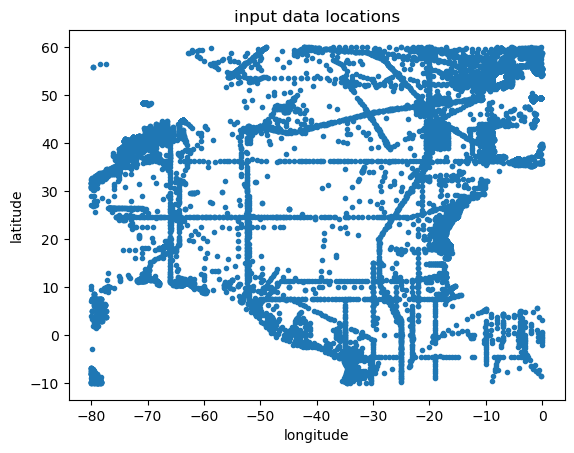

In [4]:
# assemble the input matrix
X=np.array([T,S,lat,lon,year,month]).T
y=np.array(tr).T
#
# first remove nan select data points 
dd = y + np.sum(X,axis=1)
ind=(np.isnan(dd)==False)&(lat>-10)&(lat<60)&(lon>-80)&(lon<0)&(year>1950)
# 
X=X[ind,:]
y=y[ind]
# plot the data distribution
plt.plot(lon[ind],lat[ind],'.')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('input data locations')

In [5]:
# normalize the input data
Xm=np.mean(X,axis=0)
Xstd=np.std(X,axis=0)
Xa=(X-Xm)/Xstd

## Split the data into training test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, y,random_state=1)

## Linear regression

In [7]:
# multiple linear regression
from sklearn import linear_model
LINreg = linear_model.LinearRegression()

In [8]:
LINreg.fit(X_train,y_train)
LINreg.score(X_test,y_test)

0.18649924776084736

4.9970190572482185


Text(0.5, 1.0, 'Linear regression')

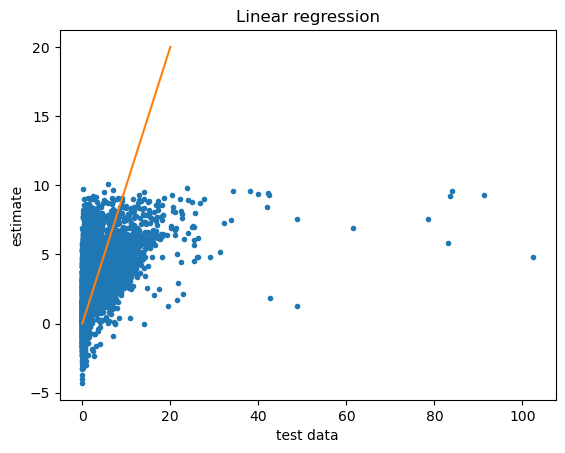

In [9]:
est = LINreg.predict(X_test)
plt.plot(y_test,est,'.')
plt.plot([0,20],[0,20],'-')
RMSE=np.sqrt(np.mean((y_test-est)**2))
print(RMSE)
plt.xlabel('test data')
plt.ylabel('estimate')
plt.title('Linear regression')

## Neural Network

In [10]:
from sklearn.neural_network import MLPRegressor
NNreg = MLPRegressor(hidden_layer_sizes=(20,20,20),random_state=1, max_iter=1000)

In [11]:
NNreg.fit(X_train, y_train)
NNreg.score(X_test,y_test)

0.6954126243647052

3.0576514379966793


Text(0.5, 1.0, 'Neural network')

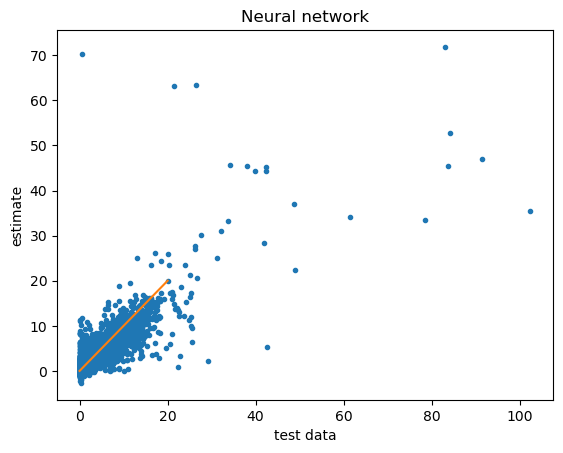

In [12]:
est = NNreg.predict(X_test)
plt.plot(y_test,est,'.')
plt.plot([0,20],[0,20],'-')
RMSE=np.sqrt(np.mean((y_test-est)**2))
print(RMSE)
plt.xlabel('test data')
plt.ylabel('estimate')
plt.title('Neural network')

## Random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor(random_state=0)

In [14]:
RFreg.fit(X_train, y_train)
RFreg.score(X_test,y_test)

0.7819143778309551

2.5872925834081677


Text(0.5, 1.0, 'Random forest')

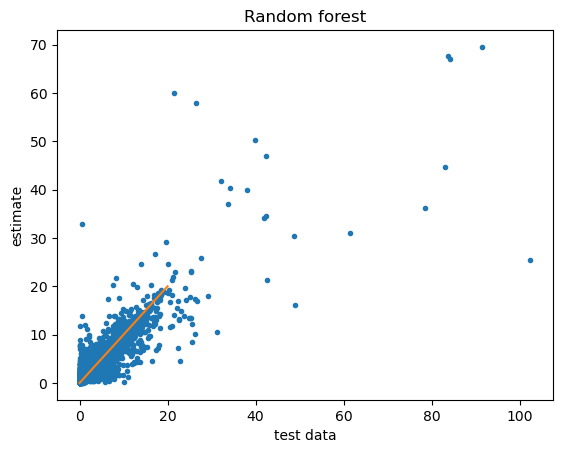

In [15]:
est = RFreg.predict(X_test)
plt.plot(y_test,est,'.')
plt.plot([0,20],[0,20],'-')
RMSE=np.sqrt(np.mean((y_test-est)**2))
print(RMSE)
plt.xlabel('test data')
plt.ylabel('estimate')
plt.title('Random forest')

## projection using observed (T,S) data
    - input is year, month, normalization for X, and regression method
    - Projection is based on observationally derived EN4 (T,S) dataset

In [16]:
def project_tr(year,month,Xm,Xstd,reg):
    ds=xr.open_dataset('EN4_SST_SSS_G10_196501_201912.nc')
    T = ds.CT.sel(time=str(year)+'-'+str(month)).sel(lat=slice(-10,60)).sel(lon=slice(-80,0))
    S = ds.SA.sel(time=str(year)+'-'+str(month)).sel(lat=slice(-10,60)).sel(lon=slice(-80,0))
    N=np.shape(T.to_numpy())
    # generate input data
    T1=np.reshape(T.to_numpy(),[N[1]*N[2],1]) 
    S1=np.reshape(S.to_numpy(),[N[1]*N[2],1])
    # coordinates
    x=ds.lon.sel(lon=slice(-80,0)).to_numpy()
    y=ds.lat.sel(lat=slice(-10,60)).to_numpy()
    xx,yy=np.meshgrid(x,y)
    x1=np.reshape(xx,[N[1]*N[2],1])
    y1=np.reshape(yy,[N[1]*N[2],1])
    yr1=np.ones((N[1]*N[2],1))*year
    mo1=np.ones((N[1]*N[2],1))*month
    # generate X array and its normalization
    X=np.array([T1,S1,y1,x1,yr1,mo1])
    # remove nan
    dd=np.sum(X,axis=0)
    ind=(np.isnan(dd)==False)
    Xa=(np.squeeze(X[:,ind]).T-Xm)/Xstd
    # project
    est = reg.predict(Xa)
    est = np.where(est<0,0,est)
    # remap 
    est1=np.nan*np.ones((N[1]*N[2],1))
    est1[ind]=est
    tr=np.reshape(est1,[N[1],N[2]])
    return x,y,tr

In [17]:
x,y,tr = project_tr(1980,12,Xm,Xstd,RFreg)

Text(0.5, 1.0, 'Nitrate : 1980-12')

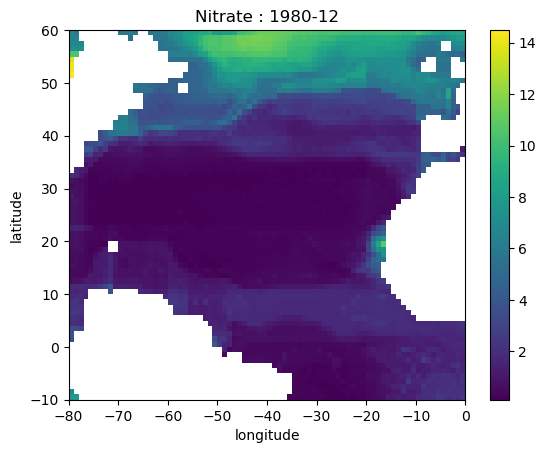

In [20]:
plt.pcolormesh(x,y,tr)
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Nitrate : 1980-12')